In [1]:
import seaborn as sns
from tqdm import tqdm

In [2]:
import pandas as pd
from rpy2.robjects import r, pandas2ri
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pandas2ri.activate()

In [5]:
r['load']("data/experiment2.rdata")

'df.l','df.w','ls.clips','ls.events'


In [8]:
S_PER_FRAME = 1/60

# Analysing object velocities (PASSIVE DATA)

In [9]:
from isaac.dataset import read_dataset

In [10]:
all_trials = read_dataset("data/passive_trials.h5")

In [15]:
concat_trials = pd.concat(all_trials)

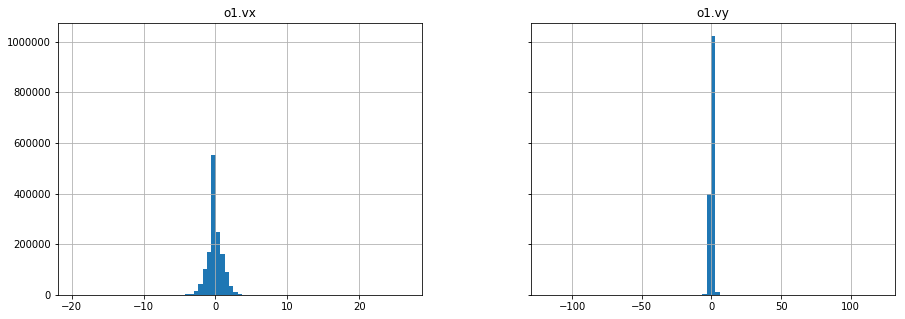

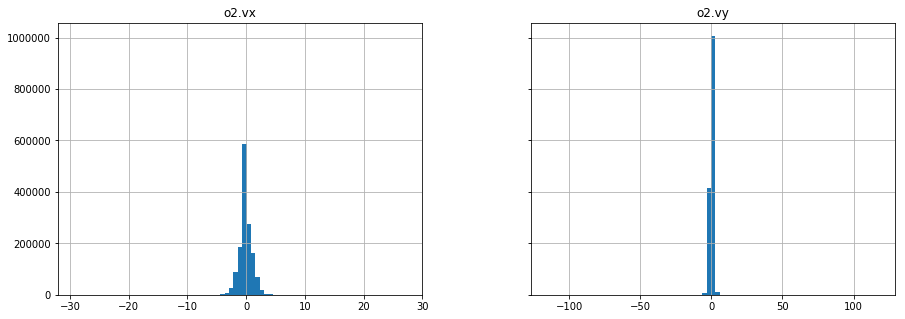

In [34]:
concat_trials[["o1.vx", "o1.vy"]].hist(bins=75, sharey=True, figsize=(15, 5))
plt.show()
concat_trials[["o2.vx", "o2.vy"]].hist(bins=75, sharey=True, figsize=(15, 5))
plt.show()

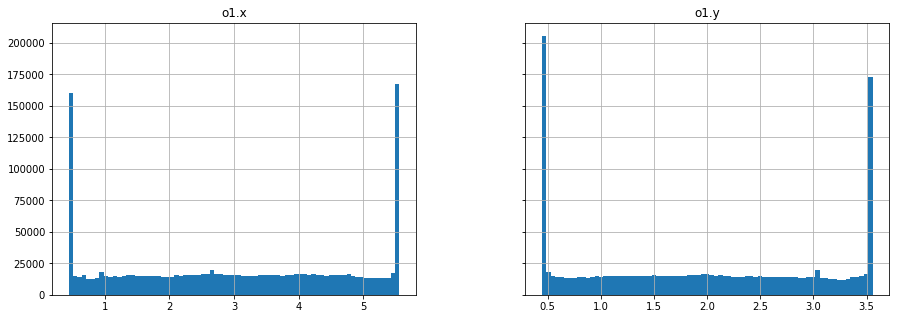

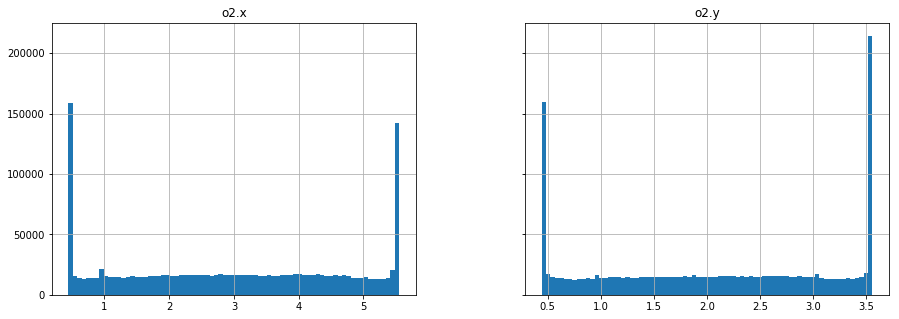

In [35]:
concat_trials[["o1.x", "o1.y"]].hist(bins=75, sharey=True, figsize=(15, 5))
plt.show()
concat_trials[["o2.x", "o2.y"]].hist(bins=75, sharey=True, figsize=(15, 5))
plt.show()

In [53]:
def transform_velocity_to_speed_and_angle(data):
    OBJECTS = ["o1", "o2", "o3", "o4"]
    
    for i, obj in enumerate(OBJECTS):
        data[obj+"_speed"] = np.sqrt(data[obj+".vx"]**2 + data[obj+".vy"]**2)        
        data[obj+"_angle"] = np.arctan(data[obj+".vy"] / data[obj+".vx"])
        # data[obj+".angle"].fillna(0, inplace=True)
        
transform_velocity_to_speed_and_angle(concat_trials)

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in arctan
  


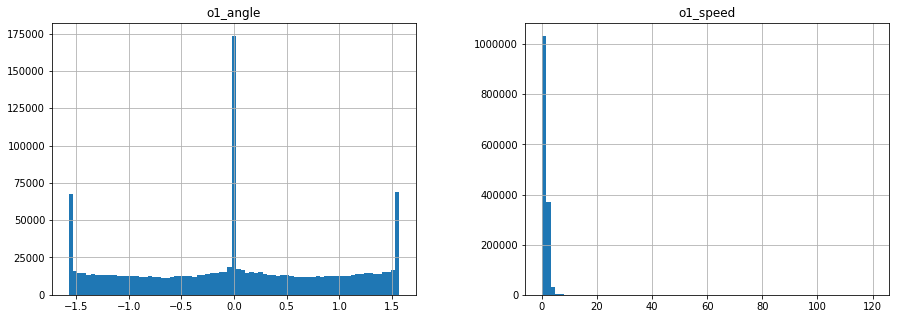

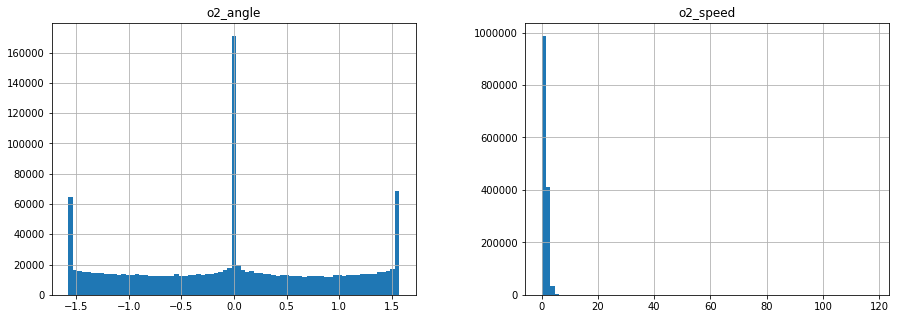

In [54]:
concat_trials[["o1_speed", "o1_angle"]].hist(bins=75, figsize=(15, 5))
plt.show()
concat_trials[["o2_speed", "o2_angle"]].hist(bins=75, figsize=(15, 5))
plt.show()

In [57]:
concat_trials.query("o1_speed < 0.25 and o2_speed < 0.25 and o3_speed < 0.25 and o4_speed < 0.25").shape[0]

31087

In [58]:
concat_trials.shape[0]

1440800

In [59]:
31087 / 1440800

0.021576207662409773

# Heatmaps of mouse locations (ACTIVE DATA)

In [6]:
def get_speed(positions):
    positions = positions / 100
    shifted_positions = positions.shift(1).fillna(positions[0])    
    return np.abs((shifted_positions - positions) / s_per_frame)

def get_row_and_col(mouse_data):
    return np.floor(mouse_data / SQUARE_SIZE).astype(int)

def get_grid_heatmap(mouse_data):
    grid_count = mouse_data.groupby(["row", "col"]).size()
        
    sns.heatmap([[grid_count.loc[(row, col)] if grid_count.index.isin([(row, col)]).any() else 0
                   for col in range(NCOLS)] for row in range(NROWS)])
    plt.show()

def get_speed_delta(speed):
    return speed.shift(1).fillna(0) - speed

In [60]:
SQUARE_SIZE = 50
WIDTH = 600
HEIGHT = 400
NROWS = int(np.ceil(HEIGHT / SQUARE_SIZE))
NCOLS = int(np.ceil(WIDTH / SQUARE_SIZE))


participants = []
for participant in tqdm(r['ls.clips']):
    trials = []
    
    for trial in participant:
        trial = pandas2ri.ri2py_dataframe(trial)
        
        if list(trial.idControlledObject.unique()) == ["none"]:
            continue

        mouse_data = trial[["mouseX", "mouseY"]].copy()
        mouse_data[["col", "row"]] = get_row_and_col(mouse_data)
        mouse_data["speed_x"] = get_speed(trial.mouseX)
        mouse_data["speed_y"] = get_speed(trial.mouseY)
        
        mouse_data["delta_vx"] = get_speed_delta(mouse_data.speed_x)
        mouse_data["delta_vy"] = get_speed_delta(mouse_data.speed_y)

        trials.append(mouse_data)
        # get_grid_heatmap(mouse_data)
    
    participants.append(trials)

  0%|          | 0/40 [00:00<?, ?it/s]/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
 50%|█████     | 20/40 [00:04<00:04,  4.40it/s]


KeyboardInterrupt: 

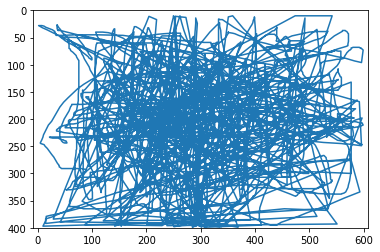

VELOCITY in X


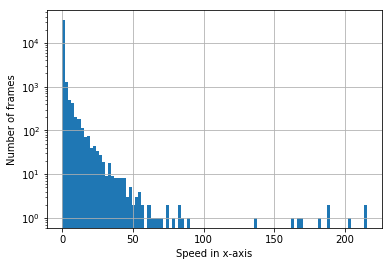

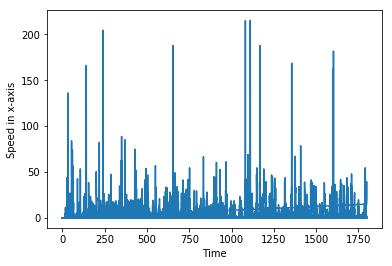

VELOCITY in Y


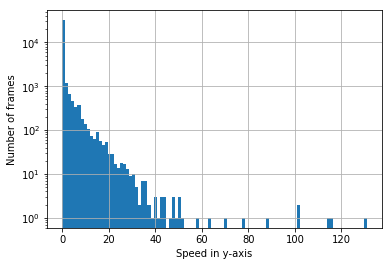

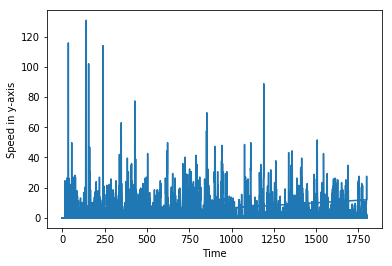

In [19]:
trials = pd.concat(participants[5])

plt.axis('equal')
plt.xlim((0, 600))
plt.ylim((0, 400))
plt.gca().invert_yaxis()
plt.plot(trials.mouseX, trials.mouseY)
plt.show()

print("VELOCITY in X")

# vel_x[vel_x != 0] = np.log(vel_x[vel_x != 0])
trials.speed_x.hist(bins=100, log=True)
plt.ylabel("Number of frames")
plt.xlabel("Speed in x-axis")
plt.show()
trials.speed_x.plot()
plt.xlabel("Time")
plt.ylabel("Speed in x-axis")
plt.show()

print("VELOCITY in Y")

# vel_y[vel_y != 0] = np.log(vel_y[vel_y != 0])
trials.speed_y.hist(bins=100, log=True)
plt.ylabel("Number of frames")
plt.xlabel("Speed in y-axis")
plt.show()
trials.speed_y.plot()
plt.xlabel("Time")
plt.ylabel("Speed in y-axis")
plt.show()